In [4]:
import sys
import os
import ctypes


# Get the absolute path of the utils directory
utils_path = os.path.abspath("lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_uop(uop, all_g, epsilon_min, seam_lst, epsilon_lst, f_orbs, total = True, ifinter = True, ifintra = True):
    e_min = np.log10(epsilon_min)//1
    print(e_min)
    nbins = len(epsilon_lst) - 1
    intra_double = np.zeros(nbins)
    inter_double = np.zeros(nbins)
    intra_control = np.zeros(nbins)
    inter_control = np.zeros(nbins)
    intra_single = np.zeros(nbins)
    inter_single = np.zeros(nbins)
    a_index = uop.a_idxs
    i_index = uop.i_idxs
    for epsilon_index in range(len(epsilon_lst) - 1):
        epsilon_min = epsilon_lst[epsilon_index+1]
        if total:
            epsilon_max = np.inf
        else:
            epsilon_max = epsilon_lst[epsilon_index]
        for [gradient, i] in all_g:
            gradient = abs(gradient)
            if gradient > epsilon_min and gradient < epsilon_max:
                cur_index = epsilon_index
                cur_a = a_index[i].copy()
                cur_i = i_index[i].copy()
                cur_excitation = [[cur_a, cur_i]]
                cur_excitation = orbital_reordering(cur_excitation,f_orbs)
                cur_a, cur_i = cur_excitation[0]
                # print(cur_a, cur_i)
                if len(cur_a) == 1:
                    if cur_a == cur_i:
                        print("single evolution")
                    else:
                        # print("single hopping")
                        i1 = min([cur_a[0], cur_i[0]])
                        i2 = max([cur_a[0], cur_i[0]])
                        if (i1 < seam_lst[0] and i2>=seam_lst[0]) or (i1 < seam_lst[1] and i2>=seam_lst[1]):
                            inter_single[cur_index] += 1
                        else:
                            intra_single[cur_index] += 1
                if len(cur_a) == 2:
                    cur_a.sort()
                    cur_i.sort()
                    p,q = cur_a
                    k,m = cur_i
                    if set(cur_a) & set(cur_i) != set():
                        j = list(set(cur_a) & set(cur_i))
                        j = j[0]
                        p,q = list(set(cur_a) ^ set(cur_i))
                        i1 = min([p,q,j])
                        i2 = max([p,q,j])
                        if (i1 < seam_lst[0] and i2>=seam_lst[0]) or (i1 < seam_lst[1] and i2>=seam_lst[1]):
                            inter_control[cur_index] += 1
                        else:
                            intra_control[cur_index] += 1
                    else:
                        index_lst = [p,q,k,m]
                        index_lst.sort()
                        i1,i2,i3,i4 = index_lst
                        if (i1 < seam_lst[0] and i4>=seam_lst[0]) or (i1 < seam_lst[1] and i4>=seam_lst[1]):
                            inter_double[cur_index] += 1
                        else:
                            intra_double[cur_index] += 1
    colors = ["red", "blue", "yellow", "green", "pink", "cyan"]
    for i in range(nbins):
        start = 0
        if ifinter:
            # Plot inter hopping
            plt.fill_betweenx([start, start+inter_double[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[0])
            start += inter_double[i]
            
            plt.fill_betweenx([start, start+inter_control[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[1])
            start += inter_control[i]

            plt.fill_betweenx([start, start+inter_single[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[2])
        if ifintra:
            # Intra hopping
            plt.fill_betweenx([start, start+intra_double[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[3])
            start += intra_double[i]

            plt.fill_betweenx([start, start+intra_control[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[4])
            start += intra_control[i]
            if intra_single[i]!=0:
                plt.fill_betweenx([start, start+intra_single[i]], np.log10(epsilon_lst[i]),np.log10(epsilon_lst[i+1]), color=colors[5])
                start += intra_single[i]

    if not ifintra:
        legend_handles = [
        mpatches.Patch(color=colors[0], label='inter double'),
        mpatches.Patch(color=colors[1], label='inter control'),
        mpatches.Patch(color=colors[2], label='inter single'),
    ]
    elif not ifinter:
        legend_handles = [
        mpatches.Patch(color=colors[3], label='intra double'),
        mpatches.Patch(color=colors[4], label='intra control'),
        mpatches.Patch(color=colors[5], label='intra single'),
    ]
    else:
        legend_handles = [
            mpatches.Patch(color=colors[0], label='inter double'),
            mpatches.Patch(color=colors[1], label='inter control'),
            mpatches.Patch(color=colors[2], label='inter single'),
            mpatches.Patch(color=colors[3], label='intra double'),
            mpatches.Patch(color=colors[4], label='intra control'),
            mpatches.Patch(color=colors[5], label='intra single'),
        ]
    if total:
        if not ifintra:
            plt.title(r"total number of inter-module excitations above $\epsilon$")
        elif not ifinter:
            plt.title(r"total number of intra-module excitations above $\epsilon$")
        else:
            plt.title(r"total number of excitations above $\epsilon$")
    else:
        if not ifintra:
            plt.title(r"inter-module excitations around $\epsilon$")
        elif not ifinter:
            plt.title(r"intra-module excitations around $\epsilon$")
        else:
            plt.title(r"excitations around $\epsilon$")

    return inter_single, intra_single, inter_control, intra_control, inter_double, intra_double

In [3]:
def find_epsilon_threshold(inter_single, inter_double, inter_control, epsilon_lst):
    first_single = next((i for i, x in enumerate(inter_single) if x != 0), np.infty)
    first_double = next((i for i, x in enumerate(inter_double) if x != 0), np.infty)
    first_control = next((i for i, x in enumerate(inter_control) if x != 0), np.infty)
    print(first_single, first_double, first_control)
    threshold_index = min(first_double, first_control, first_single)
    threshold_index = int(threshold_index)
    threshold_epsilon = epsilon_lst[threshold_index+1]
    return threshold_epsilon

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
[[-5.691350756235726e-07, 0], [-5.691350756237369e-07, 1], [3.60138657072578e-05, 2], [3.601386570725641e-05, 3], [-3.584429337516161e-05, 4], [-3.584429337516042e-05, 5], [5.972922845095476e-07, 6], [5.97292284506727e-07, 7], [8.69314382623625e-09, 8], [8.693143826182093e-09, 9], [2.112584276844532e-06, 10], [2.112584276844315e-06, 11], [3.2585053827599064e-08, 12], [3.2585053827836246e-08, 13], [8.879768183891057e-07, 14], [8.879768183891635e-07, 15], [-9.306800789927478e-07, 16], [-9.306800789929265e-07, 17], [-3.950539938270618e-08, 18], [-3.95053993826922e-08, 19], [-8.781884552139584e-07, 20], [-8.781884552150982e-07, 21], [-3.406178944825479e-08, 22], [-3.406178944824792e-08, 23], [-5.748719221074587e-09, 24], [-5.748719221061035e-09, 25], [1.2122335248492198e-06, 26], [1.2122335248492971e-06, 27], [-3.62455436271173e-09, 28], [-3.624554362655771e-09, 29], [9.570991987637846e-07, 30], [9.5709919876

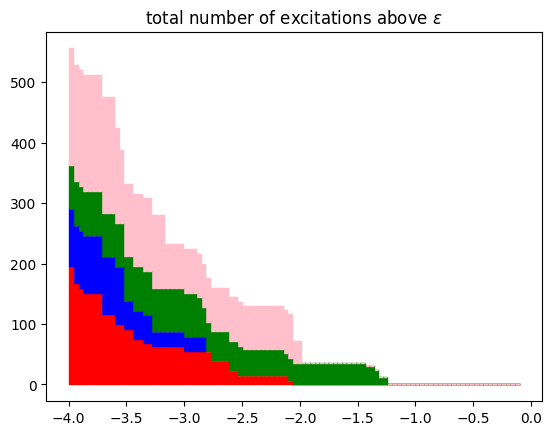

In [94]:
epsilon = 0.001
read_epsilon = 1.0
distance = 1.0
distance = float(distance)
prehead = "../H_12_cluster/"
uop, all_g = read_uop(distance, read_epsilon,prehead)
print(all_g)
epsilon_lst = [3e-3, 1e-3, 7e-4, 5e-4, 3e-4, 1e-4, 7e-5, 5e-5, 3e-5, 1e-5]
# epsilon_lst = [1e-3, 7e-4, 5e-4]
epsilon_lst = np.linspace(0.1,4,100)
epsilon_lst = 10**-(epsilon_lst)
f_orbs = [2,2,2,2,2,2]
epsilon_lst = np.array(epsilon_lst)
seam_lst = [8,16]
inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, seam_lst,epsilon_lst, f_orbs, total=True)
print(inter_double)
threshold_epsilon = find_epsilon_threshold(inter_single, inter_double, inter_control, epsilon_lst)
print(threshold_epsilon)
print(np.log10(threshold_epsilon))

cur distance is 2.1
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
-5.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8.]
inf 88 inf
0.0019630406500402704
log10 -2.707070707070707
excitation has length 128
current ratio is 1
6144
384
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 1920
current ratio is 2
6272
512
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding wi

OverflowError: cannot convert float infinity to integer

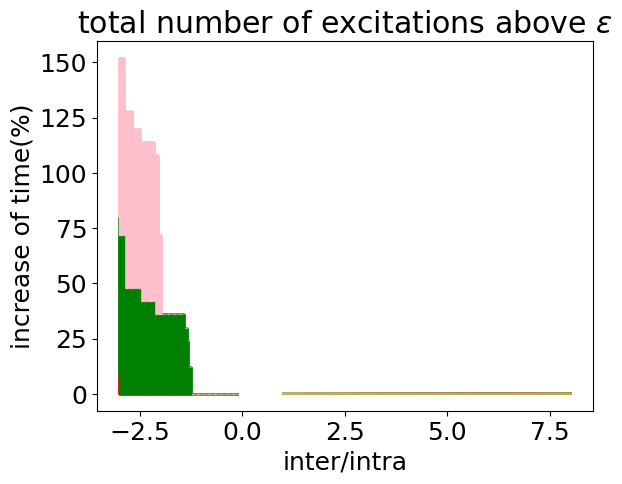

In [10]:
seam_lst = [8,16]
f_orbs = (2,2,2,2,2,2)
read_epsilon = 1.0
distance_lst = np.arange(2.1,3.1,0.1)
distance_lst = np.round(distance_lst, 1)
for distance in distance_lst:
    print(f"cur distance is {distance}")
    prehead = "../H_12_cluster/"
    uop, all_g = read_uop(distance, read_epsilon, prehead)
    epsilon_lst = np.linspace(0.1,3,100)
    epsilon_lst = 10**-(epsilon_lst)

    inter_single, intra_single, inter_control, intra_control, inter_double, intra_double = plot_uop(uop, all_g, 1e-5, seam_lst,epsilon_lst, f_orbs, total=True)
    print(inter_double)
    threshold_epsilon = find_epsilon_threshold(inter_single, inter_double, inter_control, epsilon_lst)
    print(threshold_epsilon)
    print(f"log10 {np.log10(threshold_epsilon)}")
    epsilon = threshold_epsilon

    excitations = create_excitation(uop, all_g, epsilon)
    print(f"excitation has length {len(excitations)}")
    ratio_lst = np.linspace(1, 8, 8, dtype="int")
    post_gate_lst = np.zeros(len(ratio_lst))
    for i in range(len(ratio_lst)):
        print(f"current ratio is {ratio_lst[i]}")
        ratio = ratio_lst[i]
        excitations = create_excitation(uop, all_g, epsilon)
        excitations = orbital_reordering(excitations, f_orbs)
        tiles = create_circuit_tile(excitations)
        tiles = process_tiles(tiles, ratio, seam_lst)
        bounding_width, placed_tiles = packing_with_c(tiles)
        post_gate_lst[i] = bounding_width * 25
    post_gate_lst = np.array(post_gate_lst)
    initial_gate = post_gate_lst[0]
    diff = post_gate_lst - initial_gate
    plt.plot(ratio_lst, diff/initial_gate)
    plt.xlabel("inter/intra")
    plt.ylabel("increase of time(%)")
    post_gate_lst.tolist()
    ratio_lst.tolist()
    initial_gate.tolist()
    result = [ratio_lst, post_gate_lst]
    np.save(f"../H_12_transition/inter_transition_cluster/distance = {distance}.npy", result)

[1700. 1744. 1796. 1840. 1888. 1944. 1982. 2040.]
[0.    0.026 0.056 0.082 0.111 0.144 0.166 0.2  ]


Text(0.5, 1.0, 'original algorithm')

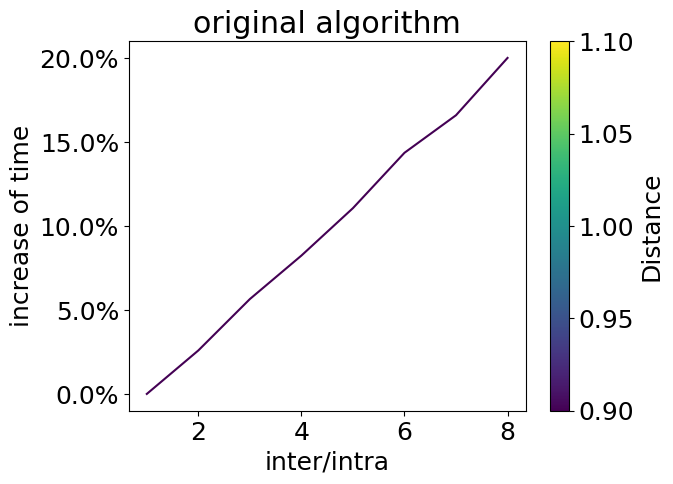

In [9]:
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
import matplotlib.cm as cm

distance_lst = np.arange(2.1,3.1,0.1)
distance_lst = [0.7, 0.8, 0.9, 1.0]
distance_lst = np.round(distance_lst, 1)
distance_lst = [1.0]
# Normalize epsilon values for color mapping
norm = mcolors.Normalize(vmin=min(distance_lst), vmax=max(distance_lst))
cmap = plt.cm.viridis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for ScalarMappable without data
# Create figure and axis
fig, ax = plt.subplots()

for distance in distance_lst:
    result = np.load(f"../H_12_transition/inter_transition_cluster/distance = {distance}.npy")
    ratio_lst1 = result[0]
    post_gate_lst1 = result[1]
    initial_gate = post_gate_lst1[0]
    print(post_gate_lst1/25)
    print(post_gate_lst1/initial_gate-1)
    diff = post_gate_lst1 - initial_gate
    color = cmap(norm(distance))
    plt.plot(ratio_lst1, diff/initial_gate, label = f"distance = {distance}",color=color)
    plt.xlabel("inter/intra")
    plt.ylabel("increase of time")
ratio_lst1 = np.array(ratio_lst1)
# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Distance')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("original algorithm")

(30, 8)
[[0.    0.108 0.216 0.324 0.432 0.541 0.649 0.757]
 [0.    0.104 0.222 0.32  0.448 0.549 0.65  0.751]
 [0.    0.043 0.106 0.151 0.197 0.242 0.321 0.383]
 [0.    0.04  0.096 0.137 0.179 0.22  0.266 0.33 ]
 [0.    0.04  0.096 0.137 0.179 0.22  0.266 0.33 ]
 [0.    0.04  0.096 0.137 0.179 0.22  0.266 0.33 ]
 [0.    0.04  0.096 0.137 0.179 0.22  0.266 0.33 ]
 [0.    0.04  0.096 0.137 0.179 0.22  0.266 0.33 ]
 [0.    0.04  0.096 0.137 0.179 0.22  0.266 0.33 ]
 [0.    0.019 0.063 0.101 0.142 0.171 0.217 0.247]
 [0.    0.026 0.056 0.082 0.111 0.144 0.166 0.2  ]
 [0.    0.009 0.034 0.061 0.095 0.118 0.143 0.17 ]
 [0.    0.009 0.034 0.061 0.095 0.118 0.143 0.17 ]
 [0.    0.009 0.034 0.061 0.095 0.118 0.143 0.17 ]
 [0.    0.009 0.034 0.061 0.095 0.118 0.143 0.17 ]
 [0.    0.009 0.034 0.061 0.095 0.118 0.143 0.17 ]
 [0.    0.009 0.034 0.061 0.095 0.118 0.143 0.17 ]
 [0.    0.008 0.031 0.056 0.087 0.108 0.131 0.156]
 [0.    0.008 0.031 0.056 0.087 0.108 0.131 0.156]
 [0.    0.008 0.031 0.0

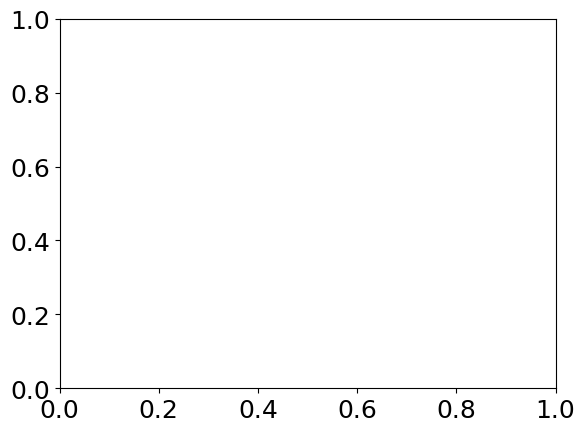

In [12]:
distance_lst = np.arange(0,3.0,0.1)
distance_lst = np.round(distance_lst, 1)
# Normalize epsilon values for color mapping
norm = mcolors.Normalize(vmin=min(distance_lst), vmax=max(distance_lst))
cmap = plt.cm.viridis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for ScalarMappable without data
# Create figure and axis
fig, ax = plt.subplots()
ratio_lst = []
diff_lst = []
initial_gate_lst = []
for distance in distance_lst:
    result = np.load(f"../H_12_transition/inter_transition_cluster/distance = {distance}.npy")
    ratio_lst.append(result[0])
    post_gate_lst1 = result[1]
    initial_gate = post_gate_lst1[0]
    initial_gate_lst.append(initial_gate)
    diff = post_gate_lst1 - initial_gate
    diff = diff/initial_gate
    diff_lst.append(diff)
ratio_lst = np.array(ratio_lst)
diff_lst = np.array(diff_lst)
print(np.shape(ratio_lst))
np.set_printoptions(precision=3)
print(diff_lst)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0.108 0.104 0.043 0.04  0.04  0.04  0.04  0.04  0.04  0.019 0.026 0.009
 0.009 0.009 0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.008 0.008 0.    0.    0.   ]
[0.216 0.222 0.106 0.096 0.096 0.096 0.096 0.096 0.096 0.063 0.056 0.034
 0.034 0.034 0.034 0.034 0.034 0.031 0.031 0.031 0.031 0.031 0.031 0.031
 0.031 0.031 0.031 0.    0.    0.   ]
[0.324 0.32  0.151 0.137 0.137 0.137 0.137 0.137 0.137 0.101 0.082 0.061
 0.061 0.061 0.061 0.061 0.061 0.056 0.056 0.056 0.056 0.056 0.056 0.056
 0.056 0.056 0.056 0.019 0.019 0.019]
[0.432 0.448 0.197 0.179 0.179 0.179 0.179 0.179 0.179 0.142 0.111 0.095
 0.095 0.095 0.095 0.095 0.095 0.087 0.087 0.087 0.087 0.087 0.087 0.087
 0.087 0.087 0.087 0.038 0.038 0.038]
[0.541 0.549 0.242 0.22  0.22  0.22  0.22  0.22  0.22  0.171 0.144 0.118
 0.118 0.118 0.118 0.118 0.118 0.108 0.108 0.108 0.108 0.108 0.108 0.108
 0.108 0.108 0.108 0.056 

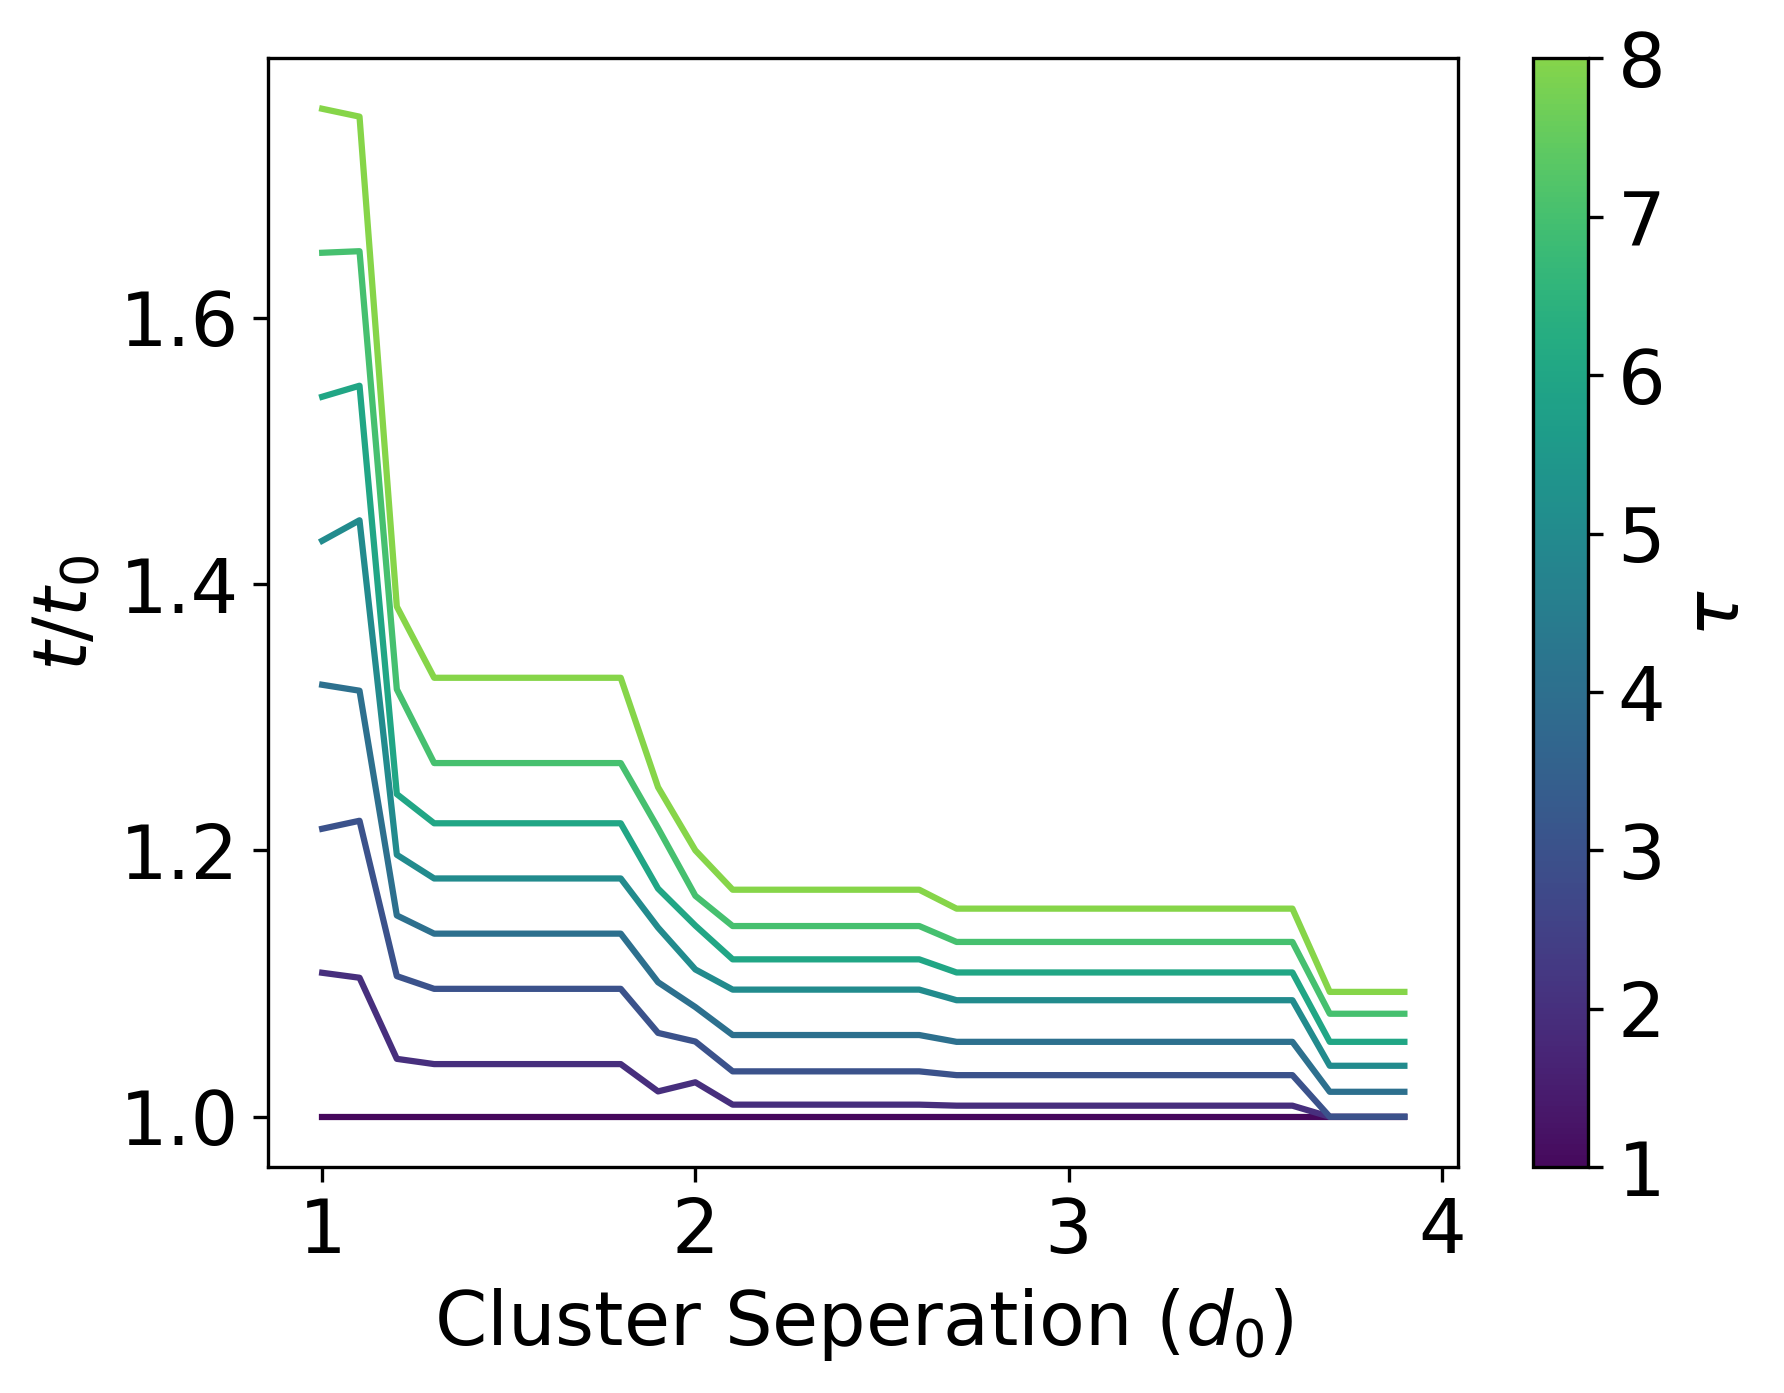

In [14]:

# plot distance threshold
norm = mcolors.Normalize(vmin=np.min(ratio_lst)*0.8, vmax=np.max(ratio_lst)*1.2)
cmap = plt.cm.viridis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for ScalarMappable without data
# Create figure and axis
fig, ax = plt.subplots(dpi=300)
for i in range(np.shape(ratio_lst)[1]):
    ratio = ratio_lst[0, i]
    diff = diff_lst[:,i]
    print(diff)
    initial_gate = initial_gate_lst[i]
    color = cmap(norm(ratio))
    plt.plot(distance_lst+1, diff+1, label = f"ratio = {ratio}",color=color)
    plt.xlabel(r"Cluster Seperation ($d_0$)")
    plt.ylabel(r"$t/t_0$")
ratio_lst1 = np.array(ratio_lst1)
# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$\tau$')
cbar.ax.set_ylim(np.min(ratio_lst), np.max(ratio_lst))

plt.rcParams.update({'font.size': 18})  # Update font size
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title(r"$H_{12}$")